For the bmi_data.xlsx dataset provided, 

- take the even-numbered subjects and fit the BMI Index distribution with using an exponential family where the sufficient statistic vector is composed of powers of the BMI Index.
- After fitting the different exponential families, plot the histogram of the odd-numbered subjects. Up to what power of the BMI Index does it seem reasonable to include in our exponential family model based on the deviation from the histogram of odd-numbered subjects?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln
from scipy.optimize import minimize
from scipy import integrate

In [2]:
bmi_data = pd.read_excel('bmi_data.xlsx')
bmi_data

,Gender,Height,Weight,BMI,Number
0,Male,198,50,12.753801,1
1,Female,198,50,12.753801,2
2,Female,196,50,13.015410,3
3,Female,190,50,13.850416,4
4,Male,190,50,13.850416,5
...,...,...,...,...,...
495,Female,140,146,74.489796,496
496,Male,140,146,74.489796,497
497,Male,145,160,76.099881,498
498,Male,140,152,77.551020,499


<BarContainer object of 20 artists>

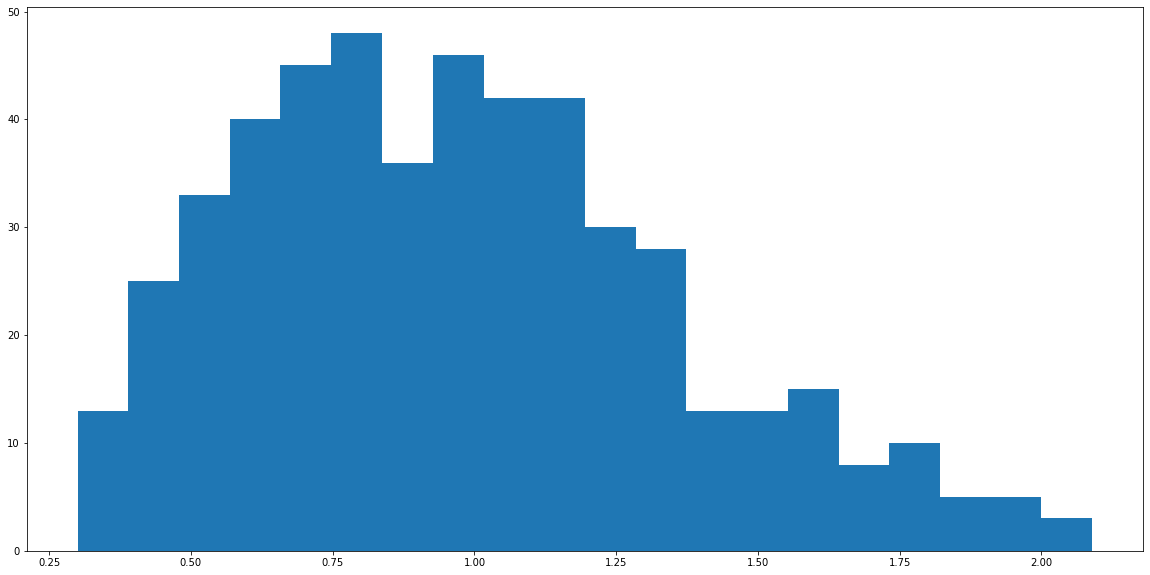

In [3]:
freqs, bins = np.histogram(bmi_data["BMI"], bins=20)
bmi_median = bmi_data["BMI"].median()
bmi_data["BMI"] = bmi_data["BMI"] / (bmi_median)
bins = bins / (bmi_median)

plt.figure(figsize=(20,10))
plt.bar(bins[:-1], freqs,width=0.09)

In [4]:
#take the even-numbered subjects
evens = bmi_data.loc[bmi_data["Number"] % 2 ==0]
odds = bmi_data.loc[bmi_data["Number"] % 2 !=0]

evens_bmi = pd.DataFrame(evens.loc[:,"BMI"])
odds_bmi = pd.DataFrame(odds.loc[:,"BMI"])

In [5]:
#take the even-numbered subjects and fit the BMI Index distribution with using an exponential family
#where the sufficient statistic vector is composed of powers of the BMI Index

for i in range(2,10):
    evens_bmi['BMI_'+ str(i)] = evens_bmi['BMI'] ** i
    
evens_bmi 

,BMI,BMI_2,BMI_3,BMI_4,BMI_5,BMI_6,BMI_7,BMI_8,BMI_9
1,0.345099,0.119093,0.041099,0.014183,0.004895,0.001689,0.000583,0.000201,0.000069
3,0.374772,0.140454,0.052638,0.019727,0.007393,0.002771,0.001038,0.000389,0.000146
5,0.392268,0.153874,0.060360,0.023677,0.009288,0.003643,0.001429,0.000561,0.000220
7,0.403991,0.163209,0.065935,0.026637,0.010761,0.004347,0.001756,0.000710,0.000287
9,0.411116,0.169016,0.069485,0.028566,0.011744,0.004828,0.001985,0.000816,0.000335
...,...,...,...,...,...,...,...,...,...
491,1.946264,3.787944,7.372341,14.348522,27.926016,54.351405,105.782194,205.880098,400.697065
493,1.974167,3.897336,7.693994,15.189231,29.986084,59.197545,116.865857,230.712751,455.465564
495,2.015583,4.062576,8.188461,16.504527,33.266249,67.050899,135.146678,272.399398,549.043699
497,2.059150,4.240098,8.730998,17.978433,37.020289,76.230325,156.969665,323.224070,665.566809


In [6]:
n = len(evens_bmi['BMI'])
suff_stats = np.array(evens_bmi.mean())
suff_stats

array([ 1.02366608,  1.19126353,  1.54307988,  2.18098592,  3.30657561,
        5.30197855,  8.88940531, 15.44301399, 27.6002443 ])

In [7]:
def psi_1p_func(alpha_0):
    f = lambda x: np.exp(alpha_0 * x  )
    integ_val = integrate.quad(f, 0.3, 2.2)[0]
    psi2_val = np.log(integ_val)
    return psi2_val

def exp_family_negative_loglik_1_par(alpha_0, n , y_bar):
    f = lambda x: np.exp(alpha_0 * x )
    integ_val = integrate.quad(f, 0.3, 2.2)[0] 
    psi_2p = np.log(integ_val)
    loglik = n * (alpha_0 * y_bar[0]  - psi_2p)
    return -loglik

theta_hat_1 = minimize(lambda theta: exp_family_negative_loglik_1_par(theta[0], n, suff_stats[:1]), 
                     (0), method='L-BFGS-B')['x']
pdf_1 = lambda df: np.exp((np.dot(df, theta_hat_1) - psi_1p_func(theta_hat_1[0])))

In [8]:
def psi_2p_func(alpha_0, alpha_1):
    
    f = lambda x: np.exp(alpha_0 * x +
                         alpha_1 * x ** 2)
    integ_val = integrate.quad(f, 0.3, 2.2)[0] 
    psi2_val = np.log(integ_val)
    
    return psi2_val

def exp_family_negative_loglik_2_par(alpha_0,
                                     alpha_1, n , y_bar):
    
    f = lambda x: np.exp(alpha_0 * x +
                         alpha_1 * x ** 2)
    integ_val = integrate.quad(f, 0.3, 2.2)[0] 
    psi_2p = np.log(integ_val)
    loglik = n * (alpha_0 * y_bar[0] + alpha_1 * y_bar[1] - psi_2p)
    
    return -loglik

theta_hat_2 = minimize(lambda theta: exp_family_negative_loglik_2_par(theta[0], theta[1], n, suff_stats[:2]), 
                     (0,0), method='L-BFGS-B')['x']

pdf_2 = lambda df: np.exp((np.dot(df, theta_hat_2) - 
                         psi_2p_func(theta_hat_2[0], theta_hat_2[1])))

In [9]:
def psi_3p_func(alpha_0, 
                alpha_1,
               alpha_2):
    
    f = lambda x: np.exp(alpha_0 * x +
                         alpha_1 * x ** 2 +
                         alpha_2 * x ** 3)
    integ_val = integrate.quad(f, 0.3, 2.2)[0] 
    psi2_val = np.log(integ_val)
    
    return psi2_val

def exp_family_negative_loglik_3_par(alpha_0,
                                     alpha_1,
                                     alpha_2,
                                     n , y_bar):
    
    f = lambda x: np.exp(alpha_0 * x +
                         alpha_1 * x ** 2 +
                         alpha_2 * x ** 3)
    integ_val = integrate.quad(f, 0.3, 2.2)[0]
    psi = np.log(integ_val)
    loglik = n * (alpha_0 * y_bar[0] +
                  alpha_1 * y_bar[1] +
                  alpha_2 * y_bar[2] - psi)
    
    return -loglik

theta_hat_3 = minimize(lambda theta: exp_family_negative_loglik_3_par(theta[0],
                                                                      theta[1],
                                                                      theta[2],
                                                                      n, suff_stats[:3]), 
                     (0,0,0), method='L-BFGS-B')['x']

pdf_3 = lambda df: np.exp((np.dot(df, theta_hat_3) - 
                         psi_3p_func(theta_hat_3[0], theta_hat_3[1], theta_hat_3[2])))

In [10]:
def psi_4p_func(alpha_0, 
                alpha_1,
               alpha_2,
               alpha_3):
    
    f = lambda x: np.exp(alpha_0 * x +
                         alpha_1 * x ** 2 +
                         alpha_2 * x ** 3 +
                         alpha_3 * x ** 4 )
    integ_val = integrate.quad(f, 0.3, 2.2)[0] 
    psi = np.log(integ_val)
    
    return psi

def exp_family_negative_loglik_4_par(alpha_0,
                                     alpha_1,
                                     alpha_2,
                                     alpha_3,
                                     n , y_bar):
    
    f = lambda x: np.exp(alpha_0 * x +
                         alpha_1 * x ** 2 +
                         alpha_2 * x ** 3 + 
                        alpha_3 * x ** 4)
    integ_val = integrate.quad(f, 0.3, 2.2)[0] 
    psi = np.log(integ_val)
    loglik = n * (alpha_0 * y_bar[0] +
                  alpha_1 * y_bar[1] +
                  alpha_2 * y_bar[2] +
                  alpha_3 * y_bar[3] - psi)
    
    return -loglik

theta_hat_4 = minimize(lambda theta: exp_family_negative_loglik_4_par(theta[0],
                                                                      theta[1],
                                                                      theta[2],
                                                                      theta[3],
                                                                      n, suff_stats[:4]), 
                     (0,0,0,0), method='L-BFGS-B')['x']

pdf_4 = lambda df: np.exp((np.dot(df, theta_hat_4) - 
                         psi_4p_func(theta_hat_4[0], theta_hat_4[1], theta_hat_4[2], theta_hat_4[3])))

In [11]:
def psi_5p_func(alpha_0, 
                alpha_1,
               alpha_2,
               alpha_3,
               alpha_4):
    
    f = lambda x: np.exp(alpha_0 * x +
                         alpha_1 * x ** 2 +
                         alpha_2 * x ** 3 +
                         alpha_3 * x ** 4 +
                        alpha_4 * x ** 5)
    integ_val = integrate.quad(f, 0.3, 2.2)[0] 
    psi = np.log(integ_val)
    
    return psi

def exp_family_negative_loglik_5_par(alpha_0,
                                     alpha_1,
                                     alpha_2,
                                     alpha_3,
                                     alpha_4,
                                     n , y_bar):
    
    f = lambda x: np.exp(alpha_0 * x +
                         alpha_1 * x ** 2 +
                         alpha_2 * x ** 3 + 
                        alpha_3 * x ** 4 +
                        alpha_4 * x ** 5)
    integ_val = integrate.quad(f, 0.3, 2.2)[0] 
    psi = np.log(integ_val)
    loglik = n * (alpha_0 * y_bar[0] +
                  alpha_1 * y_bar[1] +
                  alpha_2 * y_bar[2] +
                  alpha_3 * y_bar[3] +
                  alpha_4 * y_bar[4]- psi)
    
    return -loglik

theta_hat_5 = minimize(lambda theta: exp_family_negative_loglik_5_par(theta[0],
                                                                      theta[1],
                                                                      theta[2],
                                                                      theta[3],
                                                                      theta[4],
                                                                      n, suff_stats[:5]), 
                     (0,0,0,0,0), method='L-BFGS-B')['x']

pdf_5 = lambda df: np.exp((np.dot(df, theta_hat_5) - 
                         psi_5p_func(theta_hat_5[0], theta_hat_5[1], theta_hat_5[2],
                                     theta_hat_5[3], theta_hat_5[4])))

In [12]:
def psi_6p_func(alpha_0, 
                alpha_1,
               alpha_2,
               alpha_3,
               alpha_4,
               alpha_5):
    
    f = lambda x: np.exp(alpha_0 * x +
                         alpha_1 * x ** 2 +
                         alpha_2 * x ** 3 +
                         alpha_3 * x ** 4 +
                        alpha_4 * x ** 5 +
                        alpha_5 * x ** 6)
    integ_val = integrate.quad(f, 0.3, 2.2)[0] 
    psi = np.log(integ_val)
    
    return psi

def exp_family_negative_loglik_6_par(alpha_0,
                                     alpha_1,
                                     alpha_2,
                                     alpha_3,
                                     alpha_4,
                                     alpha_5,
                                     n , y_bar):
    
    f = lambda x: np.exp(alpha_0 * x +
                         alpha_1 * x ** 2 +
                         alpha_2 * x ** 3 + 
                        alpha_3 * x ** 4 +
                        alpha_4 * x ** 5 +
                        alpha_5 * x ** 6)
    integ_val = integrate.quad(f, 0.3, 2.2)[0] 
    psi = np.log(integ_val)
    loglik = n * (alpha_0 * y_bar[0] +
                  alpha_1 * y_bar[1] +
                  alpha_2 * y_bar[2] +
                  alpha_3 * y_bar[3] +
                  alpha_4 * y_bar[4] +
                  alpha_5 * y_bar[5] - psi)
    
    return -loglik

theta_hat_6 = minimize(lambda theta: exp_family_negative_loglik_6_par(theta[0],
                                                                      theta[1],
                                                                      theta[2],
                                                                      theta[3],
                                                                      theta[4],
                                                                      theta[5],
                                                                      n, suff_stats[:6]), 
                     (0,0,0,0,0,0), method='L-BFGS-B')['x']

pdf_6 = lambda df: np.exp((np.dot(df, theta_hat_6) - 
                         psi_6p_func(theta_hat_6[0], theta_hat_6[1], theta_hat_6[2],
                                     theta_hat_6[3], theta_hat_6[4], theta_hat_6[5])))

In [13]:
def psi_7p_func(alpha_0, 
                alpha_1,
               alpha_2,
               alpha_3,
               alpha_4,
               alpha_5,
               alpha_6):
    
    f = lambda x: np.exp(alpha_0 * x +
                         alpha_1 * x ** 2 +
                         alpha_2 * x ** 3 +
                         alpha_3 * x ** 4 +
                        alpha_4 * x ** 5 +
                        alpha_5 * x ** 6+
                         alpha_6 * x ** 7 )
    integ_val = integrate.quad(f, 0.3, 2.2)[0] 
    psi = np.log(integ_val)
    
    return psi

def exp_family_negative_loglik_7_par(alpha_0,
                                     alpha_1,
                                     alpha_2,
                                     alpha_3,
                                     alpha_4,
                                     alpha_5,
                                    alpha_6,
                                     n , y_bar):
    
    f = lambda x: np.exp(alpha_0 * x +
                         alpha_1 * x ** 2 +
                         alpha_2 * x ** 3 + 
                        alpha_3 * x ** 4 +
                        alpha_4 * x ** 5 +
                        alpha_5 * x ** 6 +
                        alpha_6 * x ** 7)
    integ_val = integrate.quad(f, 0.3, 2.2)[0] 
    psi = np.log(integ_val)
    loglik = n * (alpha_0 * y_bar[0] +
                  alpha_1 * y_bar[1] +
                  alpha_2 * y_bar[2] +
                  alpha_3 * y_bar[3] +
                  alpha_4 * y_bar[4] +
                  alpha_5 * y_bar[5] +
                  alpha_6 * y_bar[6] - psi)
    
    return -loglik

theta_hat_7 = minimize(lambda theta: exp_family_negative_loglik_7_par(theta[0],
                                                                      theta[1],
                                                                      theta[2],
                                                                      theta[3],
                                                                      theta[4],
                                                                      theta[5],
                                                                      theta[6],
                                                                      n, suff_stats[:7]), 
                     (0,0,0,0,0,0,0), method='L-BFGS-B')['x']

pdf_7 = lambda df: np.exp((np.dot(df, theta_hat_7) - 
                         psi_7p_func(theta_hat_7[0], theta_hat_7[1], theta_hat_7[2],
                                     theta_hat_7[3], theta_hat_7[4], theta_hat_7[5], theta_hat_7[6])))

In [14]:
def psi_8p_func(alpha_0, alpha_1,
             alpha_2, alpha_3,
             alpha_4, alpha_5,
             alpha_6, alpha_7):
    
    f = lambda x: np.exp(alpha_0 * x +
                         alpha_1 * x ** 2 +
                         alpha_2 * x ** 3 +
                         alpha_3 * x ** 4 +
                         alpha_4 * x ** 5 +
                         alpha_5 * x ** 6 +
                         alpha_6 * x ** 7 +
                         alpha_7 * x ** 8 )
    
    integ_val = integrate.quad(f, 0.3, 2.2)[0] 
    psi_val = np.log(integ_val)
    return psi_val

def exp_family_negative_loglik_8p(alpha_0, alpha_1, alpha_2, alpha_3, alpha_4, alpha_5, alpha_6,
             alpha_7,
                               n , y_bar):
    
    f = lambda x: np.exp(alpha_0 * x +
                         alpha_1 * x ** 2 +
                         alpha_2 * x ** 3 +
                         alpha_3 * x ** 4 +
                         alpha_4 * x ** 5 +
                         alpha_5 * x ** 6 +
                         alpha_6 * x ** 7 +
                         alpha_7 * x ** 8 )
    
    integ_val = integrate.quad(f, 0.3, 2.2)[0] #integrate over the sampel space (see abobe hist)
    psi = np.log(integ_val)
    loglik = n * (alpha_0 * y_bar[0] +
                  alpha_1 * y_bar[1] +
                  alpha_2 * y_bar[2] +
                  alpha_3 * y_bar[3] +
                  alpha_4 * y_bar[4] +
                  alpha_5 * y_bar[5] +
                  alpha_6 * y_bar[6] +
                  alpha_7 * y_bar[7] - psi)
    
    return -loglik

theta_hat_8 = minimize(lambda theta: exp_family_negative_loglik_8p(theta[0], theta[1],
                                                              theta[2], theta[3],
                                                              theta[4], theta[5],
                                                              theta[6], theta[7],
                                                              n,suff_stats),
                     (0,0,0,0,0,0,0,0),
                     method='L-BFGS-B')["x"]

pdf_8 = lambda df: np.exp((np.dot(df, theta_hat_8) - 
                         psi_8p_func(theta_hat_8[0], theta_hat_8[1], 
                                      theta_hat_8[2], theta_hat_8[3],
                                      theta_hat_8[4], theta_hat_8[5],
                                      theta_hat_8[6], theta_hat_8[7]) ))


In [15]:
def psi_9p_func(alpha_0, alpha_1,
             alpha_2, alpha_3,
             alpha_4, alpha_5,
             alpha_6, alpha_7,
             alpha_8):
    
    f = lambda x: np.exp(alpha_0 * x +
                         alpha_1 * x ** 2 +
                         alpha_2 * x ** 3 +
                         alpha_3 * x ** 4 +
                         alpha_4 * x ** 5 +
                         alpha_5 * x ** 6 +
                         alpha_6 * x ** 7 +
                         alpha_7 * x ** 8 +
                         alpha_8 * x ** 9 )
    
    integ_val = integrate.quad(f, 0.3, 2.2)[0] 
    psi_val = np.log(integ_val)
    return psi_val

def exp_family_negative_loglik_9p(alpha_0, alpha_1, alpha_2, alpha_3, alpha_4, alpha_5, alpha_6,
             alpha_7, alpha_8,
                               n , y_bar):
    
    f = lambda x: np.exp(alpha_0 * x +
                         alpha_1 * x ** 2 +
                         alpha_2 * x ** 3 +
                         alpha_3 * x ** 4 +
                         alpha_4 * x ** 5 +
                         alpha_5 * x ** 6 +
                         alpha_6 * x ** 7 +
                         alpha_7 * x ** 8 +
                         alpha_8 * x ** 9 )
    
    integ_val = integrate.quad(f, 0.3, 2.2)[0] #integrate over the sampel space (see abobe hist)
    psi = np.log(integ_val)
    loglik = n * (alpha_0 * y_bar[0] +
                  alpha_1 * y_bar[1] +
                  alpha_2 * y_bar[2] +
                  alpha_3 * y_bar[3] +
                  alpha_4 * y_bar[4] +
                  alpha_5 * y_bar[5] +
                  alpha_6 * y_bar[6] +
                  alpha_7 * y_bar[7] +
                  alpha_8 * y_bar[8] - psi)
    
    return -loglik

theta_hat_9 = minimize(lambda theta: exp_family_negative_loglik_9p(theta[0], theta[1],
                                                              theta[2], theta[3],
                                                              theta[4], theta[5],
                                                              theta[6], theta[7],
                                                              theta[8],
                                                              n,suff_stats),
                     (0,0,0,0,0,0,0,0,0),
                     method='L-BFGS-B')["x"]

pdf_9 = lambda df: np.exp((np.dot(df, theta_hat_9) - 
                         psi_9p_func(theta_hat_9[0], theta_hat_9[1], 
                                      theta_hat_9[2], theta_hat_9[3],
                                      theta_hat_9[4], theta_hat_9[5],
                                      theta_hat_9[6], theta_hat_9[7],
                                      theta_hat_9[8]) ))




In [16]:
BMI_grid = np.linspace(0.25,2.25, 200)
x_grid = pd.DataFrame({'BMI':BMI_grid, 
                       'BMI_2':BMI_grid ** 2,
                       'BMI_3':BMI_grid ** 3,
                       'BMI_4':BMI_grid ** 4,
                       'BMI_5':BMI_grid ** 5,
                       'BMI_6':BMI_grid ** 6,
                       'BMI_7':BMI_grid ** 7,
                       'BMI_8':BMI_grid ** 8,
                       'BMI_9':BMI_grid ** 9,
                      })

In [17]:
#pdf_vals = evens_bmi.apply(pdf, axis=1)
pdf_vals_1p = x_grid[['BMI']].apply(pdf_1, axis=1)
pdf_vals_2p = x_grid[['BMI', 'BMI_2']].apply(pdf_2, axis=1)
pdf_vals_3p = x_grid[['BMI', 'BMI_2','BMI_3']].apply(pdf_3, axis=1)
pdf_vals_4p = x_grid[['BMI', 'BMI_2','BMI_3','BMI_4']].apply(pdf_4, axis=1)
pdf_vals_5p = x_grid[['BMI', 'BMI_2','BMI_3','BMI_4','BMI_5']].apply(pdf_5, axis=1)
pdf_vals_6p = x_grid[['BMI', 'BMI_2','BMI_3','BMI_4','BMI_5','BMI_6']].apply(pdf_6, axis=1)
pdf_vals_7p = x_grid[['BMI', 'BMI_2','BMI_3','BMI_4','BMI_5','BMI_6','BMI_7']].apply(pdf_7, axis=1)
pdf_vals_8p = x_grid[['BMI', 'BMI_2','BMI_3','BMI_4','BMI_5','BMI_6','BMI_7','BMI_8']].apply(pdf_8, axis=1)
pdf_vals_9p = x_grid.apply(pdf_9,axis=1)

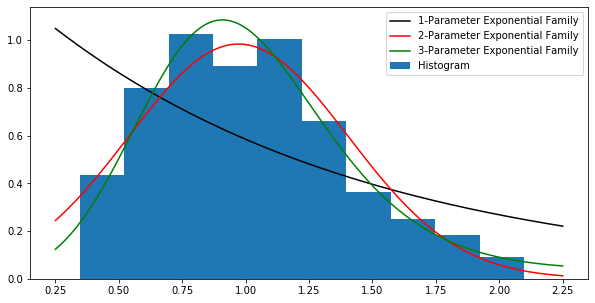

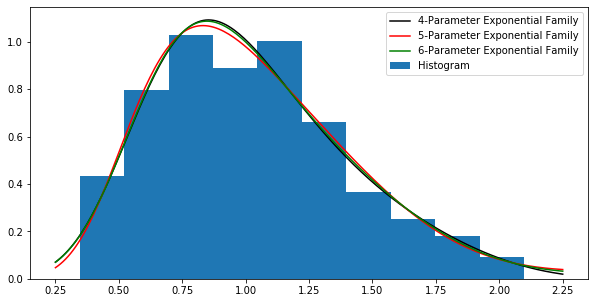

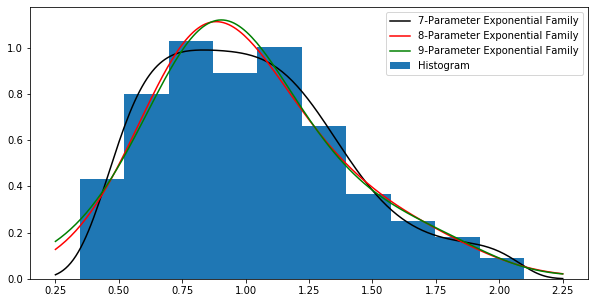

In [18]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
plt.hist(odds_bmi["BMI"], density=True)
ax.plot(BMI_grid, pdf_vals_1p, '-k')
ax.plot(BMI_grid, pdf_vals_2p, '-r')
ax.plot(BMI_grid, pdf_vals_3p, '-g')
ax.legend(['1-Parameter Exponential Family', '2-Parameter Exponential Family',
           '3-Parameter Exponential Family','Histogram'])

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
plt.hist(odds_bmi["BMI"], density=True)
ax.plot(BMI_grid, pdf_vals_4p, '-k')
ax.plot(BMI_grid, pdf_vals_5p, '-r')
ax.plot(BMI_grid, pdf_vals_6p, '-g')
ax.legend(['4-Parameter Exponential Family', '5-Parameter Exponential Family',
           '6-Parameter Exponential Family','Histogram'])

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
plt.hist(odds_bmi["BMI"], density=True)
ax.plot(BMI_grid, pdf_vals_7p, '-k')
ax.plot(BMI_grid, pdf_vals_8p, '-r')
ax.plot(BMI_grid, pdf_vals_9p, '-g')
ax.legend(['7-Parameter Exponential Family', '8-Parameter Exponential Family',
           '9-Parameter Exponential Family','Histogram'])